# Project Proposal

## Introduction

Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question


We will be using the Heart Disease dataset from UCI, linked here:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease
Specifically, we used the Cleveland Processed Data,
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

The dataset contains data regarding heart disease patients and relavant information such as sex, age, cholesterol, max heart rate and more. Other columns include more technical terms, but many we will not be using as predictors. More information on our predictors will follow.

Heart disease refers to several types of heart related sicknesses such as heart attacks, unstable angina and may more. This data set categorizes the result of the patient's diagnosis to 4 types of categories: typical angina, atypical angina, non-anginal pain, and asymptomatic. We will be generalizing this to no heart disease (0) and heart disease (1).

One of the most common causes of death is heart disease. Claiming the lives of millions every year, the battle against heart disease is paramount. The most important step in treating heart disease is to first diagnose it. For this dataset, we will be using the age, fbs, cholesterol and resting blood pressure. Fbs refers to fasting blood sugar, which is the glucose level in blood after a fasting period. Resting blood pressure is blood pressure, which refers to the pressure exerted by blood flowing in the body at rest. Further explanation on why we are using these predictors are below. This dataset was taken from the UCI machine learning repository, specifically the Cleveland dataset which takes data of heart disease patients from Long Beach and Cleveland Clinic Foundation, taken in 1988. “Num” refers to if the patient has heart disease or not, with 0 meaning no and values ranging up to four indicating the stage of the heart diseases. The higher the number, the more severe the heart disease and close to heart failure. For the pupose of this project, we will be considering the presence of heart disease (from values 1 to 4) and 0 (absence of heart disease).

We are trying to answer the question how can we predict heart disease given a patient's cholesterol levels, blood sugar levels, blood pressure and age.


## Preliminary exploratory data analysis:

In [7]:
 ### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

ERROR: Error in library(ggtext): there is no package called ‘ggtext’


- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.


### Cleaning and Reading the Data

In [2]:
# reading the data, it does not have columns
heart_disease <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"),
                         col_names = FALSE)

# labelling columns, which are absent in the original dataset
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "rbp", "cholesterol", 
                      "fbs", "rer",
                      "max_heart_rate","eia", "STdep",
                      "slope","ca", "thal", "num")

# choosing only relevant predictors
heart_disease <- heart_disease |> select(age, rbp, cholesterol, fbs, num)

# changing categorical data to factors
heart_disease <- heart_disease |> 
        mutate(fbs = as_factor(fbs), num = as_factor(num))

# renaming heart disease categories to absence or presence
heart_disease <- heart_disease |>
             mutate(num = case_when(num == 0 ~ "absence", 
                                    num == 1 ~ "presence",
                                    num == 2 ~ "presence",
                                    num == 3 ~ "presence",
                                    num == 4 ~ "presence"))


heart_disease



Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,rbp,cholesterol,fbs,num
<dbl>,<dbl>,<dbl>,<fct>,<chr>
63,145,233,1,absence
67,160,286,0,presence
67,120,229,0,presence
⋮,⋮,⋮,⋮,⋮
57,130,131,0,presence
57,130,236,0,presence
38,138,175,0,absence


In [3]:
 # Splitting the data
heart_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [4]:
## Table of data analysis

# Getting the mean of the age 
average_age <- heart_train |> summarise(mean(age))

# Number of observations of patients (number of patients/data)
num_obs <- tibble(nrow(heart_train))

# average of serum cholesterol, which is total cholesterol in body, used as a predictor
avg_chol <- heart_train |> summarise(mean(cholesterol))


# number of patients with fasting blood sugar greater than 120 mg/dl, "1" being greater
with_fbs <- heart_train |> filter(fbs == "1")
num_fbs <- tibble(nrow(with_fbs))


# average of resting blood pressure 
avg_rbp <- heart_train |> summarise(mean(rbp))

# number of people with heart disease (any type) 
num_presence <- heart_train |> filter(num == "presence")
num_hd <- tibble(nrow(num_presence))

# putting together to one table
data_analysis <- bind_cols(num_obs, average_age, avg_chol, avg_rbp, num_fbs, num_hd)

colnames(data_analysis)  <- c("Number of Observations", "Average Age", "Average Serum Cholesterol in mg/dl", "Avergae Resting Blood Pressure (mmHg), High", "Number of patients with blood sugar > 120 mg/dl", "Number of Patients with Diagnosed Heart Disaese")

data_analysis


Number of Observations,Average Age,Average Serum Cholesterol in mg/dl,"Avergae Resting Blood Pressure (mmHg), High",Number of patients with blood sugar > 120 mg/dl,Number of Patients with Diagnosed Heart Disaese
<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
227,54.35242,246.4758,131.5066,34,104


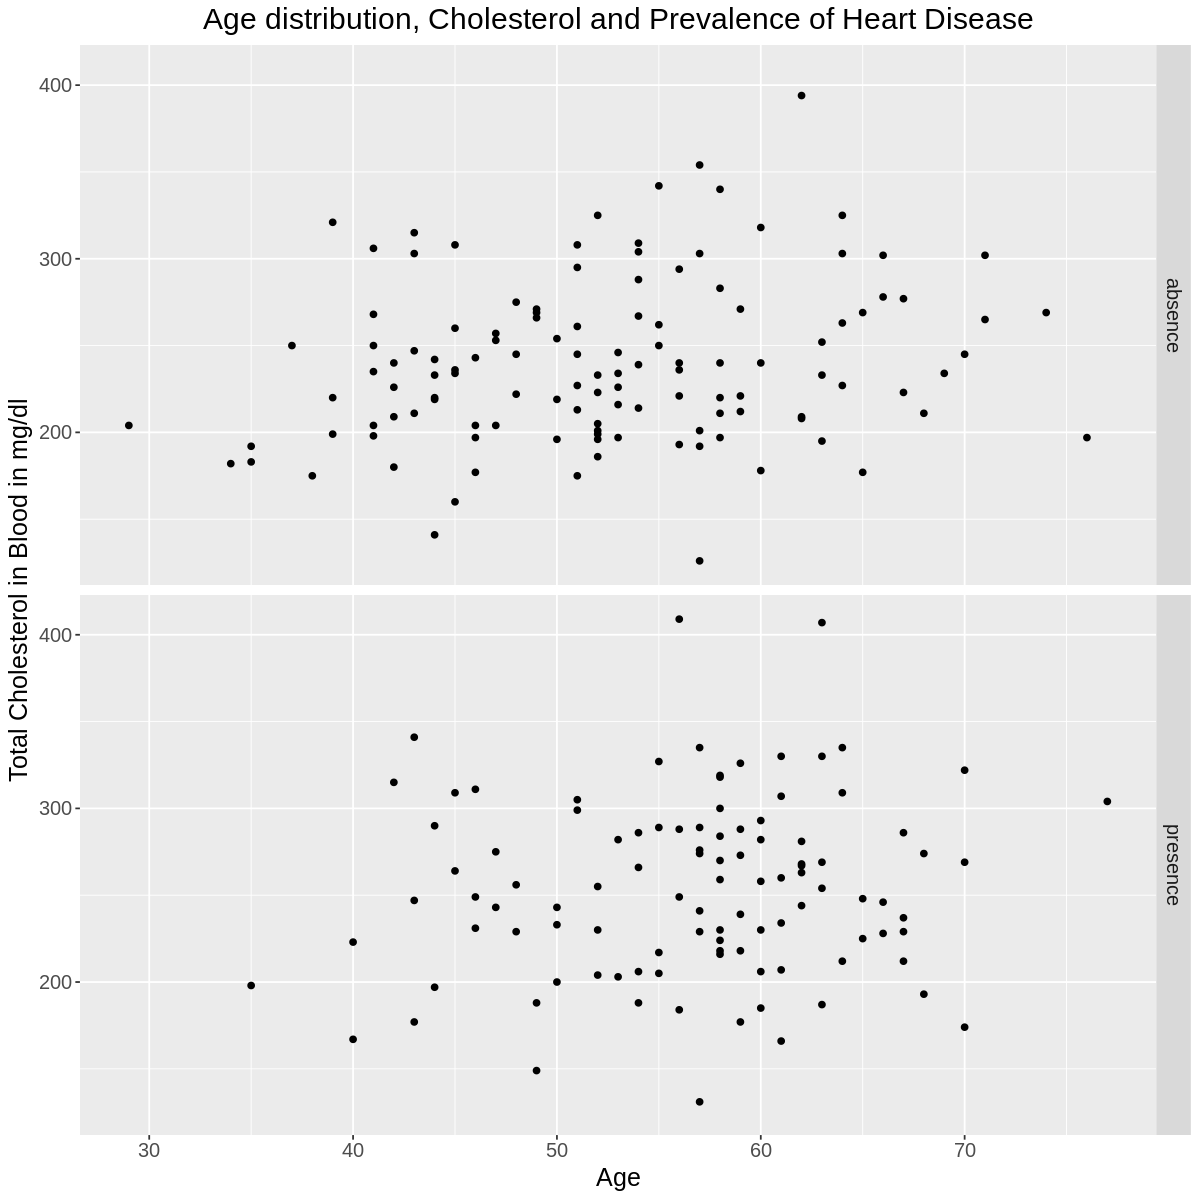

In [15]:
# plotting for data analysis
options(repr.plot.width = 10, repr.plot.height = 10) 

age_dist <- heart_train |> ggplot(aes(x=age, y = cholesterol)) + geom_point() + 
            facet_grid(rows = vars(num)) + 
            labs(x = "Age", y="Total Cholesterol in Blood in mg/dl") +
            ggtitle("Age distribution, Cholesterol and Prevalence of Heart Disease") +
            theme(text=element_text(size=15)) +
            theme(plot.title = element_text(hjust = 0.5))
age_dist

The table summarizes the average of age, which can tell us that the age distribution is reasonably around 54, and have good amount of representation, shown in the scatter plot. This helps us know that the dataset is a good representation of heart disease patients in terms of age. 

We have also averaged the predictors such as average cholesterol, average resting blood pressure, and counted the number of patients with heart disease. This gives us insight in how it compares with actual averages in real life. For example, average serum cholesterol is around 200 to 240 mg/dl (milligrams per deciliter), which show that this dataset and higher than average serum cholesterol in their blood. With regards to resting blood pressure, which the dataset most likely refer to the upper number, is 131 mm Hg (millimeters mercury). This is slightly higher than the safe level, almost to hypertension level (dangerous). The number of patients with blood sugar over 120 mg/dl is 34 out of 227 observations. Blood sugar level over 120 mg/dl is diabetes, which we expect to contribute to heart disease. We see that there are not too many diabetic patients in the whole dataset.


The plot shows use a scatter plot that is grouped for the patients diagnosed with heart disease and those that are not, against the total amount of cholesterol in their blood. From the graph only, we do not see much correlation with high cholesterol with the presence and absence of heart disease, but further analysis may show otherwise.


## Methods

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea.
- For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

We will be using age, fasting blood sugar, resting heart rate and cholesterol levels as predictors for our data analysis.  One way we will visualize our results is by creating graphs on Jupyter using the tidyverse's "ggplot" function.  Some of our data is categorical and some are quantitative, so we can create separate graphs for each. For example, we will make a scatterplot for our blood pressure plotted against age, and group them if they have presence or absence of heart disease (making them colored). This will show us if there is any correlation between age and blood pressure, and see if the higher the age and cholesterol, the likelier the chance of the patient having heart disease. We will also use classification and regression to predict whether or not new patients will develop heart disease based on their age, blood pressure, etc.  We will plot these patients' data on our graphs as well and show their "k-nearest neighbors" function.  

Predictors:

Age:
	According to the National Institute on Aging, individuals that are older have a higher likelihood of having heart disease. This is the case as there is an “increased stiffness of large arteries” that contributes to the “buildup of fatty deposits in the walls of arteries.”

https://www.nia.nih.gov/health/heart-health-and-aging

Fasting Blood Sugar (Diabetes):
	Having a higher fasting blood sugar level is an indicator for diabetes. According to the Centers for Disease Control and Prevention, having a diabetes “can damage blood vessels and the nerves that control your heart.”

https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls.


Cholesterol: 
	According to clevelandclinic, cholesterol “leads to a buildup of plaque inside your blood vessels”. This buildup of plaque then “limits how much blood can flow,” thus, causing heart disease as well as other medical conditions.
	
https://my.clevelandclinic.org/health/articles/11918-cholesterol-high-cholesterol-diseases



Resting Blood Pressure:
	According to the Centers for Disease Control and Prevention, having a higher resting blood pressure can “damage arteries by making them less elastic.” This leads to being less blood flow to the heart.

https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina.


In [7]:
#We will be using age, resting blood pressure, and resting heart rate as predictors for our data analysis.

heart_disease_data <- heart_disease |>
    select(age, fbs, cholesterol, rbp, num)

#heart_disease_data
#The recipe: Age, FBS, Cholesterol, RPB as predictors. We will be using the training data set (heart_train)
heart_disease_recipe <- recipe(num ~ age + fbs + cholesterol + rbp, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


#Set knn_spec to classification using the kknn engine for the project. We will test out multiple 'K' values, therefore we set neighbors to tune()
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#We will set up cross-validation (5 fold)
heart_vfold <- vfold_cv(heart_train, v = 5, strata = num)

#heart_vfold



## Expected outcomes and significance:

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

We expected to find age as a leading predictor for heart disease. We also expect cholesterol to be a good predictor for specific heart disease too.  The impact of this could be very beneficial.  For example, people could be screened for high cholesterol levels as they get older to prevent heart disease.  If a person is older and is found to have high cholesterol, they could adapt a healthier lifestyle and prevent a heart attack or other disaster. Some future questions this could lead to include why age leads to an increased risk of heart disease, and how to help people who are genetically predisposed to have higher levels of cholesterol.